# Project Overview

This notebook contains two from-scratch implemented multi-class classifier models which trained and tested on both an artificial dataset and Digits dataset. In addition to the from-scratch implemented classifiers, I also used the most similar classifiers implemented by the `sklearn` library to compare the results of both sides. Every classifier used in this notebook, whether it's implemented from-scratch or implemented by `sklearn` library is using **linear** models as it's hypothesis. One of the two from-scratch implementations is using the **multi-class hinge loss** as it's loss function (as the multi-class Support Vector Machine (SVM) method does), and the other is using the **cross-entopy or softmax** as it's loss function (as the multi-class Logistic Regression method does).

So if we want to picture an overview of what have been done in this notebook, it's possible to divide it into the following parts:
 * Implement the from-scratch Support Vector Machine (SVM) classifier.
 * Implement the from-scratch Logistic Regression classifier.
 * Train the both from-scratch SVM and Logistic Regressison models on an artificially created dataset, then test and compare the results and accuracies.
 * Train the both sklearn SVM and Logistic Regresison models on the artificially created dataset, then test and compare the results and accuracies.
 * Train the both from-scratch SVM and Logistic Regressison models on an **Digits** dataset, then test and compare the results and accuracies.
 * Train the both sklearn SVM and Logistic Regresison models on the **Digits** dataset, then test and compare the results and accuracies.
    

---
As always, the first cell contains instructions to import the used modules, also the last line contains the instruction to set `ggplot` as the used plot style in this notebook.

In [2]:
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

plt.style.use('ggplot')

---
### Dataset 1
---
The artificially Created dataset using `make_classification` function of `sklearn.datasets` module, which contains 250 samples with two features (because of visualization purposes), and three classes.

In the following cell the dataset is created by calling `make_classification` function.

In [3]:
N_classes = 3

data = make_classification(n_samples=250, n_features=2, n_classes=N_classes, n_redundant=0, n_informative=2, 
                           hypercube=True, n_clusters_per_class=1, class_sep=1.6, random_state=5)

Dividing the created dataset into train and test datasets using `train_test_split` function.

In [4]:
X = data[0]
y = data[1]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=3)

Plot the whole dataset (including both train and test samples) and denote the test samples by a circle around them.

Text(0, 0.5, 'feature 2')

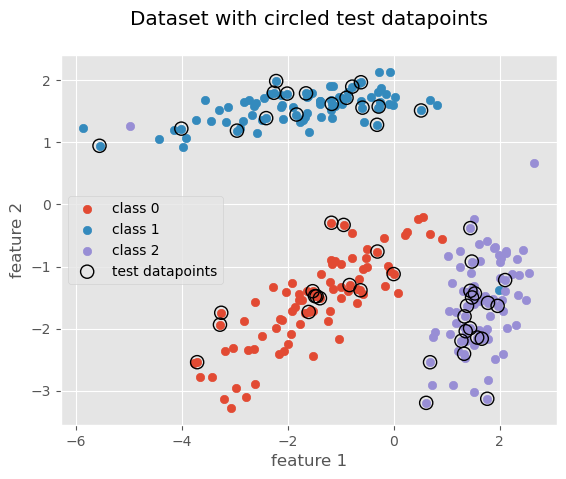

In [5]:

for i in range(N_classes):
    class_i = X[y == i]
    plt.scatter(class_i[:, 0], class_i[:, 1], label=f'class {i}')

plt.scatter(X_test[:, 0], X_test[:, 1], facecolor='none', edgecolor='black', s=90, label='test datapoints', linewidths=1)

plt.title('Dataset with circled test datapoints\n')
plt.legend() # loc='lower left')
plt.xlabel('feature 1')
plt.ylabel('feature 2')

---
### Dataset 2 : Digits
---

The second dataset used in this notebook is the **Digits** (https://en.wikipedia.org/wiki/Digits_database) dataset, which contains 1797 of 8*8 images which each of them pictures a single handwritten digit. In the next cell this dataset loaded using `load_Digits` function of `sklearn.datasets` module.

In [6]:
from sklearn.datasets import load_digits

Digits = load_digits()
Digits.keys()

dict_keys(['data', 'target', 'frame', 'feature_names', 'target_names', 'images', 'DESCR'])

Dividing the created dataset into train and test datasets using `train_test_split` function.

In [7]:
Digits_X = Digits.data
Digits_y = Digits.target

X_train_mn, X_test_mn, y_train_mn, y_test_mn = train_test_split(Digits_X, Digits_y, test_size=0.2, random_state=3)

Pick the first ten samples of the datast and picture them as 8*8 image in gray scale.

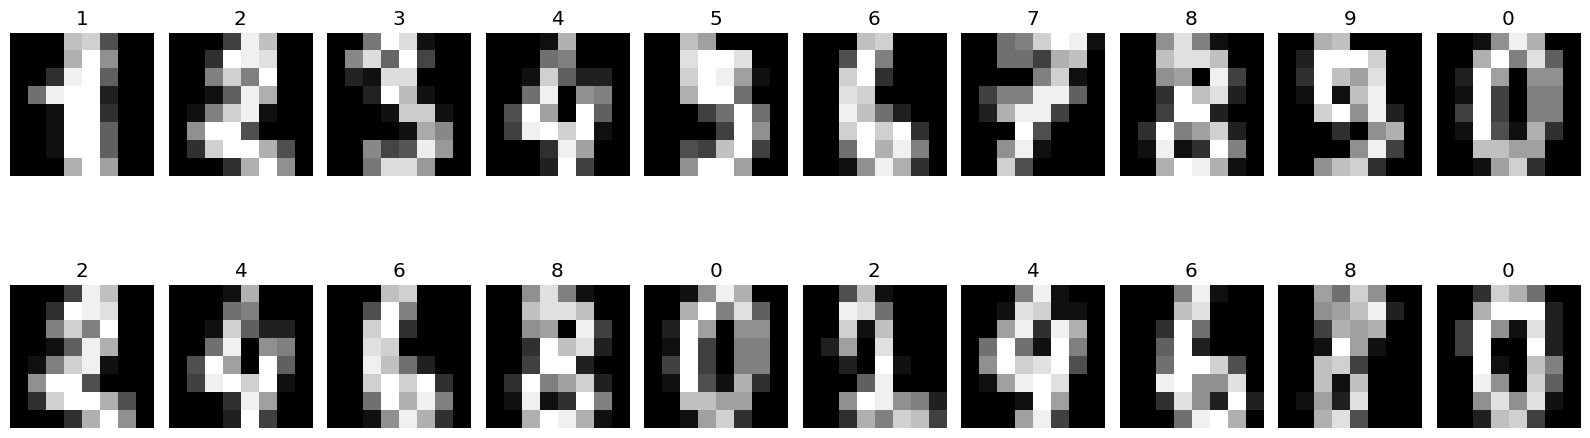

In [8]:
fig, axs = plt.subplots(2, 10, figsize=(16, 6))
for i in range(2):
    for j in range(10):
        axs[i, j].imshow(Digits_X[(i+1) * (j+1)].reshape(8, 8), cmap='gray')
        axs[i, j].set_title(Digits_y[(i+1) * (j+1)])
        axs[i, j].axis('off')
plt.tight_layout()

A function to plot loss/accuracy of a model on train/test datasets.

In [9]:
def loss_acc_plotter(title, loss_on_train, loss_on_test, accs_on_train, accs_on_test):
    """
    A function to plot loss/accuracy on train/test datasets.

    Inputs:
        - title: the name of the model
        - loss_on_train: An array-shaped object containing loss values on train dataset.
        - loss_on_test: An array-shaped object containing loss values on test dataset.
        - accs_on_train: An array-shaped object containing accuracies on train dataset.
        - accs_on_test: An array-shaped object containing accuracies on test dataset.
        
    Outputs:
        - Two plots.
    """
    fig, axs = plt.subplots(1, 2, figsize=(15, 5))

    axs[0].plot(np.arange(len(loss_on_train)), np.array(loss_on_train), label='loss on train')
    axs[0].plot(np.arange(len(loss_on_test)), np.array(loss_on_test), label='loss on test')
    axs[0].set_title(f"Loss ({title})\n")
    axs[0].set_xlabel('Iteration')
    axs[0].set_ylabel('Loss')
    axs[0].legend()

    axs[1].plot(np.arange(len(accs_on_train)), np.array(accs_on_train), label='accuracy on train')
    axs[1].plot(np.arange(len(accs_on_test)), np.array(accs_on_test), label='accuracy on test')
    axs[1].set_title(f"Accuracy ({title})\n")
    axs[1].set_xlabel('Iteration')
    axs[1].set_ylabel('Accuracy')
    axs[1].legend()

Create a function to draw the decision surface for a given model in a 2-D plot.

In [10]:
def decision_surface(classifier, ax, X, n_classes):
    """
    A function to draw the decision surface for a given model in a 2-D plot.

    Inputs:
        - classifier: a classifier object
        - ax: An matplotlib.pyplot axes object
        - X: the whole dataset used in model (including both train and test sets).
        - n_classes: the number of classes

    Outputs:
        - An plot containing the decision surface for the given classifier.
    """
    # define bounds of the domain
    min1, max1 = X[:, 0].min()-1, X[:, 0].max()+1
    min2, max2 = X[:, 1].min()-1, X[:, 1].max()+1
    # define the x and y scale
    x1grid = np.arange(min1, max1, 0.1)
    x2grid = np.arange(min2, max2, 0.1)
    # create all of the lines and rows of the grid
    xx, yy = np.meshgrid(x1grid, x2grid)
    # flatten each grid to a vector
    r1, r2 = xx.flatten(), yy.flatten()
    r1, r2 = r1.reshape((len(r1), 1)), r2.reshape((len(r2), 1))
    # horizontal stack vectors to create x1,x2 input for the model
    grid = np.hstack((r1,r2))
    # make predictions for the grid
    yhat = classifier.predict(grid)
    # reshape the predictions back into a grid
    zz = yhat.reshape(xx.shape)
    # plot the grid of x, y and z values as a surface
    ax.contourf(xx, yy, zz, cmap='Set3', alpha=0.7)
    # plot the datapoints
    for i in range(n_classes):
        class_i = X[y == i]
        ax.scatter(class_i[:, 0], class_i[:, 1], label=f'class {i}')
    ax.legend()

---
### **From-Scratch SVM class**
---
In the following cell, there is a class named `svm_classifier`, which provides us the from-scratch version of Support Vector Machine (SVM) with a linear decision boundary.

#### **Hypothesis representation** 
Linear function (dot product of the input data and theta parameters): 
$$ s = \theta^TX = \theta_0 x^{(i)}_0 + \theta_1 x^{(i)}_1 + ... + \theta_n x^{(i)}_n \qquad\qquad i = 1,2,...,m \quad,\quad m\text{ is the number of samples} \quad,\quad n\text{ is the number of features}$$
$$ (\theta = w) $$


#### **Cost function**
The used mathematical function to represent the loss function in this module is **multi-class hinge class** which also used in SVM algorithm (which reveals why this module named `svm_classifier`). The $ s_j $ is the calculated score for the $j_{th}$ class, which as defined above, it's the dot product of the input data and theta parameters :
$$ \qquad\qquad\qquad\qquad L_i = \sum_{j=1, j \neq y_i}^{c} max(0, s_j - {s_y}_i + \Delta) \qquad\qquad y_i : \text{correct class} \quad,\quad c\text{ is the number of classes} $$


In this notebook, we set the value of $\Delta$ to 1.


#### **Optimization method**
The optimization method used in this example is gradient descent, which calculates the gradients relative to each parameter/weight and updates the parameters/weights accordingly:
$$\qquad\qquad\qquad\qquad\qquad\qquad\qquad \dfrac{∂}{∂w}L_i=\sum_{j=1, j \neq y_i}^{c} max(0, s_j - {s_y}_i + \Delta) \qquad\qquad y_i : \text{correct class} \quad,\quad c\text{ is the number of classes}$$

This functions has different procedures to calculate the derivative of Loss function with respect to the weights/parameters of correct class, and the derivative of Loss function with respect to the weights/parameters of incorrect class. Which for the correct class, i.e., $ j=y_i $:
$$ \dfrac{∂L_i}{∂s_{y_i}} \cdot \dfrac{∂s_{y_i}}{∂w_i} = - \left(\sum_{j=1, j \neq y_i}^{m}1(w^T_jx_i - w^T_{y_i}x_i + \Delta > 0)\right)x_i$$

And for the incorrect classes, i.e., $ j\neq y_i $:
$$ \dfrac{∂L_i}{∂s_j} \cdot \dfrac{∂s_j}{∂w_i} = 1(w^T_jx_i - w^T_{y_i}x_i + \Delta > 0)x_i$$


*reference* : https://aman.ai/primers/backprop/derivative-svm/

**Note**: here we are using full batch gradient descent, which that means in each update of weights/parameters, we are using the whole dataset to estimate how badly our model is performing.

In [11]:
class svm_classifier:
    def __init__(self, reg, alpha, n_features, n_classes):
        self.reg = reg                                                              # regularization coefficient
        self.alpha = alpha                                                          # step coefficient for gradient descent algorithm
        self.n_features = n_features    
        self.n_classes = n_classes
        self.Ws = self.weight_initializer(n_features=self.n_features, n_classes=n_classes)

    def hypothesis(self, X, apply_padding=False):
        if apply_padding:                                                           # as wer consider 'W' and 'b' as a signle matrix, we should pad 'X' mattrix with new column with values of one
            X = np.concatenate((X, np.ones(X.shape[0]).reshape(-1, 1)), axis=1)     # and if apply_padding parameter is set to True, this padding will occur.
        score = np.dot(X, self.Ws)                                                  # as our model/hypothesis function is a simple linear function, we use dot product to calculate the scores
        return score

    def weight_initializer(self, n_features, n_classes):
        np.random.seed(3)                                                           # initialize the weights matrix (including bias vector) with random values
        W = np.random.randn(n_features, n_classes)
        np.random.seed(3)
        b = np.random.randn(n_classes)
        parameters = np.concatenate((W, b.reshape(-1, b.shape[0])))                 # Concatenate "W" array and "b" array into a one single ndarray.
        return parameters
    
    def naive_multiclass_hinge_loss(self, X, y):
        """ this method will calculate the loss of model on X matrix. and this calculation is done using naive implementation of multiclass hinge loss function. """
        X = np.concatenate((X, np.ones(X.shape[0]).reshape(-1, 1)), axis=1)         # add a column on one values to the 'X' matrix, which this new column will play its part due to dot product of 'X' and self.Ws matrices, and this new column is defined for the bias values.
        N = X.shape[0]                                                              # N = number of the training samples
        X = X.reshape(N, -1)                                                        # Convert the X array from any shape into a two dimensional array which the first element of it's shape represents the number of samples and the second element of it's shape represents the number of features.
        total_loss = 0       
        for i in range(N):                                                          # first loop is through each sample
            sample = X[i]
            scores = self.hypothesis(sample)
            correct_class = scores[y[i]]
            loss_on_each_sample = 0
            for j in range(len(scores)):                                            # loop over the calculated scores for each class and implement the multiclass hinge loss function to calculate loss for each sample
                if j == y[i]:
                    continue
                loss_on_each_sample += max(0, scores[j] - correct_class + 1)
            total_loss += loss_on_each_sample                                       # sum all the losses on each sample to estimate the total loss
        total_loss /= N                                                             # devide the total loss over the number of samples

        total_loss = total_loss + self.reg * np.sum(self.Ws * self.Ws)              # Adding L2 regularization loss into the overall loss function.

        return total_loss


    def half_vectorized_multiclass_hinge_loss(self, X, y):
        """ this method will calculate the loss of model on X matrix. and this calculation is done using half vectorized implementation of multiclass hinge loss function. """
        X = np.concatenate((X, np.ones(X.shape[0]).reshape(-1, 1)), axis=1)         # add a column on one values to the 'X' matrix, which this new column will play its part due to dot product of 'X' and self.Ws matrices, and this new column is defined for the bias values.
        N = X.shape[0]
        X = X.reshape(N, -1)
        total_loss = 0
        for i in range(N):                                                          # the only loop that this method consists of is the loop over each sample and there is no loop over calcuculated scores, and the process of calculating the loss of each sample is vectorzed in this method
            sample = X[i]
            scores = self.hypothesis(sample)
            correct_class_score = scores[y[i]]
            margins = np.maximum(np.zeros(scores.shape), scores - correct_class_score + 1)
            margins[y[i]] = 0
            total_loss += margins.sum() 
        total_loss /= N

        total_loss = total_loss + self.reg * np.sum(self.Ws * self.Ws)              # Adding L2 regularization loss into the overall loss function.

        return total_loss

    def full_vectorized_multiclass_hinge_loss(self, X, y):
        """ this method will calculate the loss of model on X matrix. and this calculation is done using full vectorized implementation of multiclass hinge loss function. """
        X = np.concatenate((X, np.ones(X.shape[0]).reshape(-1, 1)), axis=1)         # add a column on one values to the 'X' matrix, which this new column will play its part due to dot product of 'X' and self.Ws matrices, and this new column is defined for the bias values.
        N = X.shape[0]                                                              # N = number of the training samples
        X = X.reshape(N, -1)                                                        # Convert the X array from any shape into a two dimensional array which the first element of it's shape represents the number of samples and the second element of it's shape represents the number of features.
        scores = self.hypothesis(X)
        
        y_scores = scores[range(N), y]                                              # Extract the computed scores for the correct classes
        margins = np.maximum(np.zeros(scores.shape), scores - y_scores.reshape(-1, 1) + 1)              # y_scores gets reshaped in order to be able to broadcast into the shape of the scores matrix 
        margins[range(N), y] = 0
        loss_without_regularization = margins.sum() / N
        
        loss = loss_without_regularization + self.reg * np.sum(self.Ws * self.Ws)                       # Adding L2 regularization loss into the overall loss function.
        return loss

    def naive_update(self, X, y):
        """
        this method will implement one iteration of the gradient descent algorithm. in other words, for each call of this method, our SVM model will be one step closer to the optimized situation.
        this method's name contains the "naive" word, as its implemented in a way that loops through each sample in 'X' matrix and another loop over each calculated scores for the sample.   
        """
        X = np.concatenate((X, np.ones(X.shape[0]).reshape(-1, 1)), axis=1)         # add a column on one values to the 'X' matrix, which this new column will play its part due to dot product of 'X' and self.Ws matrices, and this new column is defined for the bias values.
        N = X.shape[0]                                                              # N = number of the training samples
        # n_features = X.shape[1] 
        scores = self.hypothesis(X)
        deltas = np.zeros((self.n_features + 1, self.n_classes))                    # deltas array here will contain the derivatives calculated for each parameter in our model 
        for i in range(N):                                                          # loop through each sample
            counter = 0                                                             # conter in here represents the number of classes which their scores+1 (1 is the margin) are more than the score of the correct class
            for j in range(self.n_classes):                                         # loop through the calculated scores of each sample 
                if j == y[i]:                                                       # check if the vlaue of 'j' is equal to the correct class number 
                    continue
                elif scores[i, j] - scores[i][y[i]] + 1 > 0 :                       # check if the calculated scores+1 for classes other than correct class are greater than the calculated score for the correct class
                    deltas[:, j] += X[i]                                            # calculate the derivative of loss fucntion with respect to ther weights of incorrect classes
                    counter += 1
            deltas[:, y[i]] += -counter * X[i]                                      # calculate the derivative of loss function with respect to the weights for the correct class
        
        deltas = deltas + 2 * self.reg * self.Ws.sum()                              # add the derivative of regularization to the deltas matrix
        self.Ws = self.Ws - self.alpha * deltas                                     # update the weights
        return deltas

    def vectorized_update(self, X, y):
        """
        this method will implement one epoch for the gradient descent algorithm. in other words, for each call of this method, our SVM model will be one step closer to the optimized situation.
        this method's name contains the "vectorized" word, as it's implemented in a way that there is no loop on either samples or calculated scores for each sample, and all the gradients for the 
        whole weight/parameter matrix is computed at once.   
        """
        X = np.concatenate((X, np.ones(X.shape[0]).reshape(-1, 1)), axis=1)
        N = X.shape[0]
        scores = self.hypothesis(X)

        y_scores = scores[range(N), y]
        deltas = ((scores - y_scores.reshape(-1, 1) + 1) > 0) * 1
        # print(scores.shape)
        deltas[range(N), y] = 0
        deltas[range(N), y] = -deltas.sum(axis=1)
        deltas = np.dot(X.T, deltas)

        deltas = deltas + 2 * self.reg * self.Ws.sum()
        self.Ws = self.Ws - self.alpha * deltas

        return deltas
    
    def predict(self, X):
        """ Return the predicted class based on the calculated scores."""
        X = np.concatenate((X, np.ones(X.shape[0]).reshape(-1, 1)), axis=1)         # add a column on one values to the 'X' matrix, which this new column will play its part due to dot product of 'X' and self.Ws matrices, and this new column is defined for the bias values.
        scores = self.hypothesis(X)
        predicted_class = scores.argmax(axis=1)
        return predicted_class

    def accuracy(self, predicted_scores, ys):
        """ This method will return the accuracy calculated by the comparison of predictions 'predicted_scores' and the original y values 'ys'."""
        predicted_ys = predicted_scores.argmax(axis=1)                            # determine the predicted class based on the calculated scores
        acc = (predicted_ys == ys).mean()
        return acc

Instantiate an classifier from the `svm_classifier` class, and then train it on the **created dataset** for 3000 iterations, in each execution of this function, the accuracy and loss function's value on both train and test data is calculated in each iteration and stored as a list for further analysis.

In [12]:
svm_obj = svm_classifier(reg=0, alpha=1e-4, n_features=2, n_classes=N_classes)

accs_on_train, accs_on_test, loss_on_train, loss_on_test = [], [], [], []

for i in range(3000):
    # estimating loss and accuracy every 100 iterations
    if i % 100 == 0:
        # calculated the both loss and accuracy on training dataset
        loss_on_train.append(svm_obj.full_vectorized_multiclass_hinge_loss(X_train, y_train))
        train_predicted_scores = svm_obj.hypothesis(X_train, True)
        accs_on_train.append(svm_obj.accuracy(train_predicted_scores, y_train))
        
        # calculated the both loss and accuracy on testing dataset
        loss_on_test.append(svm_obj.full_vectorized_multiclass_hinge_loss(X_train, y_train))
        test_predicted_scores = svm_obj.hypothesis(X_test, True)
        accs_on_test.append(svm_obj.accuracy(test_predicted_scores, y_test))
    
    svm_obj.vectorized_update(X_train, y_train)

After the training of the SVM classifier object `svm_obj`, plot the decision surface for it using `decision_surface` function.

Text(0.5, 1.0, 'Dicision Boundary on implementd SVM')

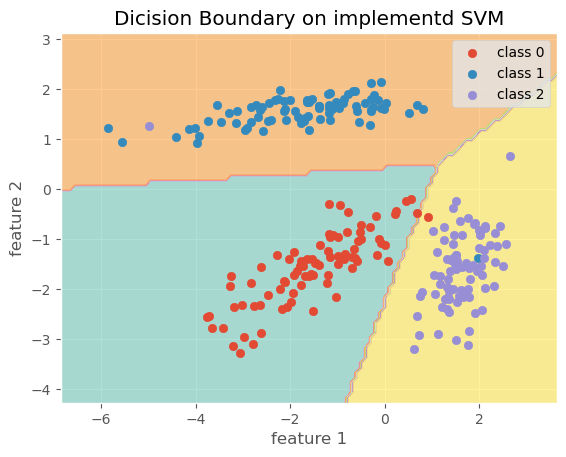

In [13]:
decision_surface(svm_obj, plt, X, N_classes)
plt.xlabel('feature 1')
plt.ylabel('feature 2')
plt.title('Dicision Boundary on implementd SVM')

The next two subplots are visualizing the behavior of loss function and accuracy on both train and test datasets as the number of training iterations increases.

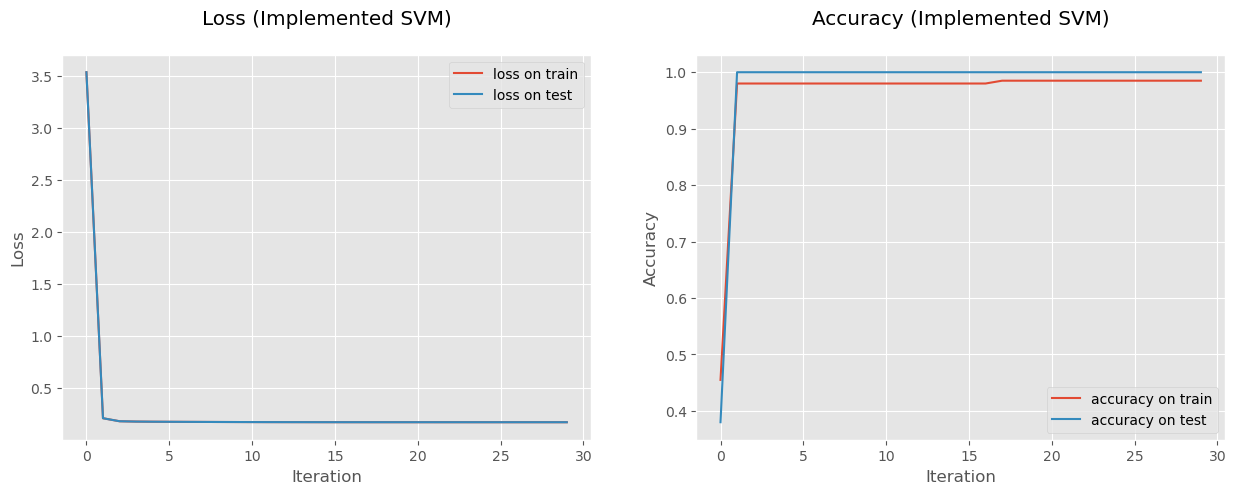

In [14]:
loss_acc_plotter("Implemented SVM", loss_on_train, loss_on_test, accs_on_train, accs_on_test)

---
### **From-Scratch Logistic Regression Class**
---
In the following cell, there is a class named `logistic_regression_classifier`, which provides us the from-scratch version of **logistic regression** classifier with a linear decision boundary.

#### **Hypothesis representation** 
The hypothesis of this model is **linear function** (dot product of the input data and theta parameters): 
$$ s = \theta^TX = \theta_0 x^{(i)}_0 + \theta_1 x^{(i)}_1 + ... + \theta_n x^{(i)}_n \qquad\qquad i = 1,2,...,m \quad,\quad m\text{ is the number of samples} \quad,\quad n\text{ is the number of features}$$
$$ (\theta = w) $$

#### **Cost function**
The used mathematical function to represent the loss function in this module is named **cross-entopy or softmax** which is used in logistic regression (which reveals why this module named `logistic_regression_classifier`). The $ s_j $ is the calculated score for the $j_{th}$ class, which as defined above, it's the dot product of the input data and theta parameters :
$$ \qquad\qquad\qquad\qquad L_i = -log\left(  \dfrac{e^{s_{y_i}}}{\sum_{j=1}^{c}e^{s_j}}  \right) = log(\sum_{j=1}^{c}e^{s_j}) - e^{s_{y_i}} \qquad\qquad y_i : \text{correct class} \quad,\quad c\text{ is the number of classes} $$ 


#### **Optimization method**
The optimization method used in this example is gradient descent, which calculates the gradients relative to each parameter/weight and updates the parameters/weights accordingly:
$$\qquad\qquad\qquad\qquad\qquad\qquad\qquad \dfrac{∂}{∂w_i}L_i=\dfrac{∂L_i}{∂s} \cdot \dfrac{∂s}{∂w_i} \qquad\qquad L_i : \text{Loss on } i_{th} \text{ sample} $$

This functions has different procedures to calculate the derivative of Loss function with respect to the weights/parameters of correct class, and the derivative of Loss function with respect to the weights/parameters of incorrect class. Which for the correct class, i.e., $ j=y_i $:
$$ \dfrac{∂L_i}{∂s_{y_i}} \cdot \dfrac{∂s_{y_i}}{∂w_i} = \left( \dfrac{e^{s_{y_i}}}{\sum_{j=1}^{c}e^{s_j}}  - 1 \right) \cdot x_i $$

And for the incorrect classes, i.e., $ j\neq y_i $:
$$ \dfrac{∂L_i}{∂s_j} \cdot \dfrac{∂s_j}{∂w_i} = \left(  \dfrac{e^{s_j}}{\sum_{j=1}^{c}e^{s_j}}  \right) \cdot x_i $$


**Note**: here we are using full batch gradient descent, which that means in each update of weights/parameters, we are using the whole dataset to estimate how badly our model is performing.

In [15]:
class logistic_regression_classifier:
    def __init__(self, reg, alpha, n_features, n_classes):
        self.reg = reg                                                              # regularization coefficient
        self.alpha = alpha                                                          # step coefficient for gradient descent algorithm
        self.n_features = n_features    
        self.n_classes = n_classes
        self.Ws = self.weight_initializer(n_features=self.n_features, n_classes=n_classes)

    def hypothesis(self, X, apply_padding=False):
        if apply_padding:                                                           # as wer consider 'W' and 'b' as a signle matrix, we should pad 'X' mattrix with new column with values of one
            X = np.concatenate((X, np.ones(X.shape[0]).reshape(-1, 1)), axis=1)     # and if apply_padding parameter is set to True, this padding will occur.
        score = np.dot(X, self.Ws)                                                  # as our model/hypothesis function is a simple linear function, we use dot product to calculate the scores
        return score

    def weight_initializer(self, n_features, n_classes):
        np.random.seed(3)                                                           # initialize the weights matrix (including bias vector) with random values
        W = np.random.randn(n_features, n_classes)
        np.random.seed(3)
        b = np.random.randn(n_classes)
        parameters = np.concatenate((W, b.reshape(-1, b.shape[0])))                 # Concatenate "W" array and "b" array into a one single ndarray.
        return parameters
    
    def softmax_naive_loss(self, X, y):
        """ this method will calculate the loss of model on X matrix. and this calculation is done using naive implementation of cross-entropy/softmax loss function."""
        X = np.concatenate((X, np.ones(X.shape[0]).reshape(-1, 1)), axis=1)         # add a column on one values to the 'X' matrix, which this new column will play its part due to dot product of 'X' and self.Ws matrices, and this new column is defined for the bias values.
        n_samples = X.shape[0]                                                      # number of samples 
        scores = self.hypothesis(X)     
        loss = 0
        for i in range(n_samples):
            exps = np.exp(scores[i, :])
            loss += -np.log(exps[y[i]] / exps.sum())
        loss /= n_samples
        loss = loss + self.reg * np.sum(self.Ws * self.Ws)              # Adding L2 regularization loss into the overall loss function.

        return loss

    def vectotrized_softmax_loss(self, X, y):
        """ this method will calculate the loss of model on X matrix. and this calculation is done using full vectorized implementation of cross-entropy/softmax loss function. """
        X = np.concatenate((X, np.ones(X.shape[0]).reshape(-1, 1)), axis=1)
        scores = self.hypothesis(X)
        exps = np.exp(scores)
        loss = -np.log(exps[range(exps.shape[0]), y] / exps.sum(axis=1))
        loss = loss.sum() / X.shape[0]
        loss = loss + self.reg * np.sum(self.Ws * self.Ws)              # Adding L2 regularization loss into the overall loss function.
        
        return loss

    def naive_update(self, X, y):
        """
        this method will implement one iteration of gradient descent algorithm. in other words, for each call of this method, our Logistic regression model will be one step closer to the optimized situation.
        this method's name contains naive word, as its implementated in a way that loops through each sample in 'X' matrix and another loop over each calculated scores for the sample.   
        """
        X = np.concatenate((X, np.ones(X.shape[0]).reshape(-1, 1)), axis=1)     # add a column on one values to the 'X' matrix, which this new column will play its part due to dot product of 'X' and self.Ws matrices, and this new column is defined for the bias values.
        n_samples = X.shape[0]
        scores = self.hypothesis(X)
        scores -= np.max(scores)                                                # subtract all the scores by the maximum score to prevent infinity values in the operation of exponentation in the next step
        probs = np.exp(scores)
        denoms = probs.sum(axis=1)                                              # calculate the denominators for each row (which means each class)
        probs =  probs / denoms.reshape(-1, 1)                                  # in this step the "prob" matrix will contain the probabilities of each class per each sample
        deltas = np.zeros((self.n_features + 1, self.n_classes))                # create a zeros matrix with a shape of "self.Ws" matrix 
        for i in range(n_samples):                                              # iterate on each sample
            for j in range(self.n_classes):                                     # iterate on calculated probabilities of each class per each sample
                                                                                # calculate the deltas for each class weights and assign it to a column of "deltas" matrix which represents the weights of a class 
                if j == y[i]:                                                   # if "j" is equal to the correct class label 
                    deltas[:, j] += (probs[i, j] - 1) * X[i]                    # add the partial derivative of weights with respect to the defined loss function in the case that "j" is equal to correct class label 
                else:                                                           
                    deltas[:, j] += probs[i, j] * X[i]                          # add the partial derivative of weights with respect to the defined loss function in the case that "j" is not equal to correct class label
        
        deltas = deltas + 2 * self.reg * self.Ws.sum()                          # add the derivative of regularization to the deltas matrix
        self.Ws = self.Ws - self.alpha * deltas                                 # update the "self.Ws" matrix using the calculated gradients
        return deltas

    def vectorized_update(self, X, y):
        """
        this method will implement one epoch for the gradient descent algorithm. in other words, for each call of this method, our Logistic regression model will be one step closer to the optimized situation.
        this method's name contains the "vectorized" word, as it's implemented in a way that there is no loop on either samples or calculated scores for each sample, and all the gradients for the 
        whole weight/parameter matrix is computed at once.   
        """
        X = np.concatenate((X, np.ones(X.shape[0]).reshape(-1, 1)), axis=1)     # add a column on one values to the 'X' matrix, which this new column will play its part due to dot product of 'X' and self.Ws matrices, and this new column is defined for the bias values.
        scores = self.hypothesis(X)
        scores -= np.max(scores)                                                # subtract all the scores by the maximum score to prevent infinity values in the operation of exponentation in the next step.
        probs = np.exp(scores)
        denoms = probs.sum(axis=1)                                              # calculate the denominators for each row (which means each class).
        probs =  probs / denoms.reshape(-1, 1)                                  # in this step the "prob" matrix will contain the probabilities of each class per each sample.
        
        # the "probs" matrix now contains the probabilities of each class per each sample, but by the definition of loss function, 
        # we know that these probabilities are also the prtial derivatives of loss function with respect to "S" (which stands for score) in 
        # the case of where the score is not for the correct class. 
        
        probs[range(X.shape[0]), y] = probs[range(X.shape[0]), y] - 1  # in this line we are converting the probabilities of the correct classes to the derivatives of loss function with respect to the score of the correct class.      
        deltas = np.dot(X.T, probs)                                    # this line is in fact applying the chain rule between the partial derivative of Loss function with respect to score "S", and the partial derivative of model/hypothesis function (which is simply the dot product of weights and 'X') with respect to Weights "self.Ws"; and we are chaining these two derivatives by applying the dot product of transposed "X" and "probs".  
                                                                       # now the "deltas" matrix contains the partial derivatives of loss function with respect to weights "self.Ws".
        deltas = deltas + 2 * self.reg * self.Ws.sum()                 # add the derivative of regularization to the deltas matrix
        self.Ws = self.Ws - self.alpha * deltas
        return deltas

    def predict(self, X):
        """ Return the predicted class based on the calculated scores."""
        X = np.concatenate((X, np.ones(X.shape[0]).reshape(-1, 1)), axis=1)         # add a column on one values to the 'X' matrix, which this new column will play its part due to dot product of 'X' and self.Ws matrices, and this new column is defined for the bias values.
        scores = self.hypothesis(X)
        predicted_class = scores.argmax(axis=1)
        return predicted_class

    def accuracy(self, predicted_scores, ys):
        """ This method will return the accuracy calculated by the comparison of predictions 'predicted_scores' and the original y values 'ys'."""
        predicted_ys = predicted_scores.argmax(axis=1)                            # determine the predicted class based on the calculated scores
        acc = (predicted_ys == ys).mean()
        return acc
        

Instantiate an classifier from the `logistic_regression_classifier` class, and then train it on **created dataset** for 3000 iterations, in each execution of this function, the accuracy and loss function's value on both train and test data is calculated in each iteration and stored as a list for further analysis.

In [16]:
log_obj = logistic_regression_classifier(reg=0, alpha=0.0003, n_features=2, n_classes=N_classes)

accs_on_train, accs_on_test, loss_on_train, loss_on_test = [], [], [], []

for i in range(3000):
    # estimating loss and accuracy every 100 iterations
    if i % 100 == 0:
        # calculated the both loss and accuracy on training dataset
        loss_on_train.append(log_obj.vectotrized_softmax_loss(X_train, y_train))
        train_predicted_scores = log_obj.hypothesis(X_train, True)
        accs_on_train.append(log_obj.accuracy(train_predicted_scores, y_train))
        
        # calculated the both loss and accuracy on testing dataset
        loss_on_test.append(log_obj.vectotrized_softmax_loss(X_train, y_train))
        test_predicted_scores = log_obj.hypothesis(X_test, True)
        accs_on_test.append(log_obj.accuracy(test_predicted_scores, y_test))
    
    log_obj.vectorized_update(X_train, y_train)

After the training of the Logistic Regression classifier object `log_obj`, plot the decision surface for it using `decision_surface` function.

Text(0.5, 1.0, 'Dicision Boundary on implementd Logistic classifier')

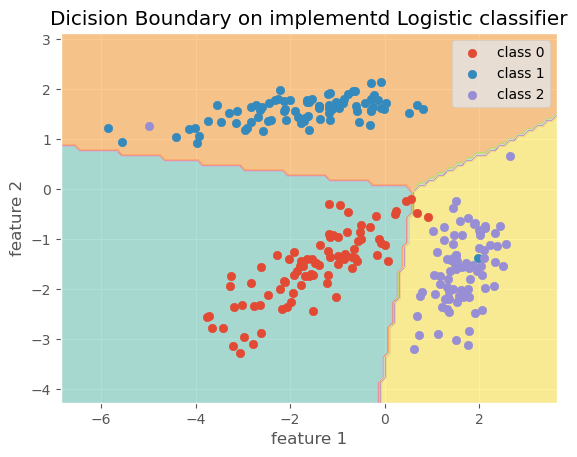

In [17]:
decision_surface(log_obj, plt, X, N_classes)
plt.xlabel('feature 1')
plt.ylabel('feature 2')
plt.title('Dicision Boundary on implementd Logistic classifier')

The next two subplots are visualizing the behavior of loss function and accuracy on both train and test datasets as the number of training iterations increases.

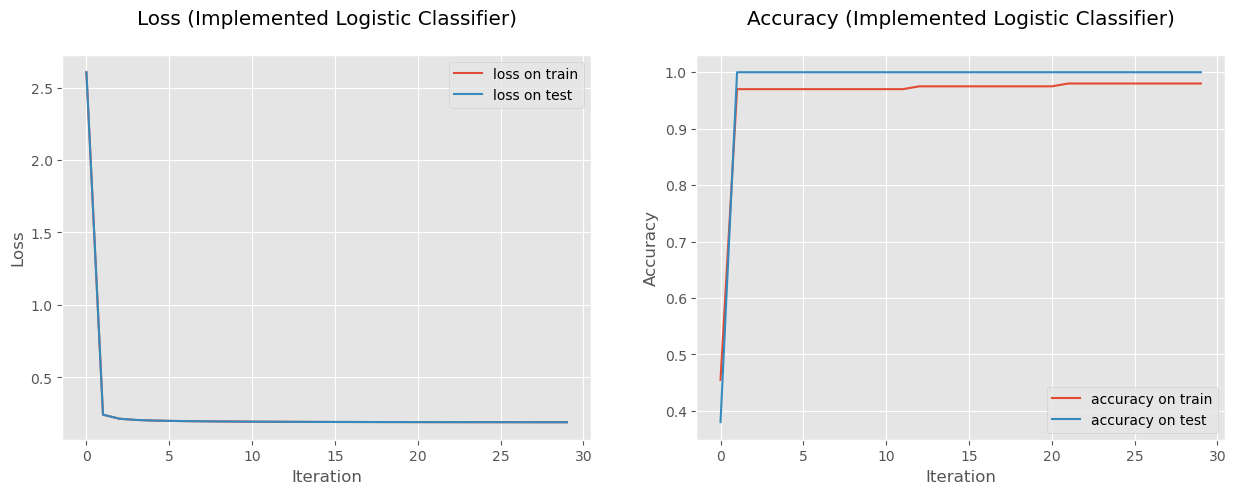

In [18]:
loss_acc_plotter("Implemented Logistic Classifier", loss_on_train, loss_on_test, accs_on_train, accs_on_test)

The next step, envolves making an animation of the training procedure for both `svm_obj` and `log_obj`, we defined an `animate` function that acts as a frame creator for our animation, in each execution of this function, we are creating two plots on the dataset and the emerging decision surface using the `decision_surface` function, and finally, update the both instances of `svm_obj` and `log_obj` class using their correponding `vectorized_update` method. We are plotting these two plots in order to compare the process of learning for each classifier. 

In [19]:
svm_obj_vis = svm_classifier(reg=0, alpha=0.0005, n_features=2, n_classes=N_classes)
log_obj_vis = logistic_regression_classifier(reg=0, alpha=0.005, n_features=2, n_classes=N_classes)

fig, axs = plt.subplots(1, 2, figsize=(10, 5))

def animate(i):
    axs[0].cla()
    axs[0].set_title('SVM Classifier\n')
    axs[0].set_xlabel('feature 1')
    axs[0].set_ylabel('feature 2')
    
    axs[1].cla()
    axs[1].set_title('Logistic Classifier\n')
    axs[1].set_xlabel('feature 1')
    axs[1].set_ylabel('feature 2')

    decision_surface(svm_obj_vis, axs[0], X, N_classes)
    decision_surface(log_obj_vis, axs[1], X, N_classes)


    svm_obj_vis.vectorized_update(X_train, y_train)
    log_obj_vis.vectorized_update(X_train, y_train)
    

ani = FuncAnimation(fig, animate, frames=200, interval=100)

plt.close()

Using `HTML` function, we have a video in output which shows how our straight-line decision boundary fits on the dataset, step by step.

The animation is available as `mutli_class_classifiers(dicision boundary).mp4` video file.

In [20]:
HTML(ani.to_html5_video())

In the next cell, we are comparing the consumed time for each implementation-type of gradient descent algorithm (naive, vectorized) in `logistic_regression_classifier` on the created dataset. 

In [21]:
iterations = 100
tic1 = time.time()
for _ in range(iterations):
    log_obj.naive_update(X_train, y_train)
toc1 = time.time()

tic2 = time.time()
for _ in range(iterations):
    log_obj.vectorized_update(X_train, y_train)
toc2 = time.time()

time1 = toc1 - tic1
time2 = toc2 - tic2

print("Logistic Classifier On Created dataset:")
print(f"In {iterations} iteration of gradient descent, the vectorized implementation will preform {time1 / time2} times faster than the naive implementation.")

Logistic Classifier On Created dataset:
In 100 iteration of gradient descent, the vectorized implementation will preform 20.155379621711585 times faster than the naive implementation.


---
### Sklearn SVM Classifier
---

In the next cell, a svm classifier with linear decision boundaries is created and trained on the created dataset.

In [22]:
from sklearn.svm import SVC

svm_clf = SVC(kernel='linear', C=100)
svm_clf.fit(X_train, y_train) 

SVC(C=100, kernel='linear')

After the training of the SVM classifier object `svm_clf`, plot the decision surface for it using `decision_surface` function.

Text(0.5, 1.0, 'Dicision Boundary on Sklearn SVM')

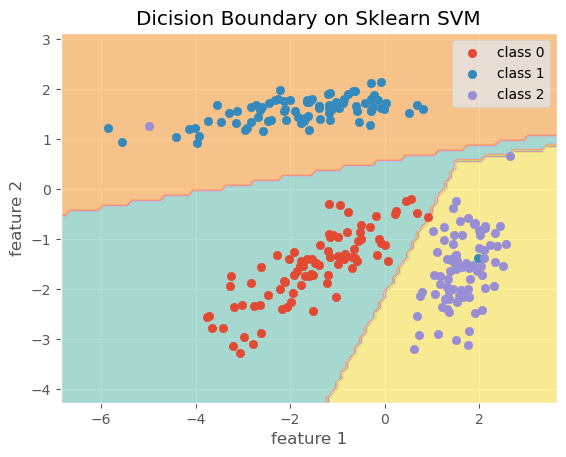

In [23]:
decision_surface(svm_clf, plt, X, N_classes)
plt.xlabel('feature 1')
plt.ylabel('feature 2')
plt.title('Dicision Boundary on Sklearn SVM')

---
### Sklearn Logistic Classifier
---

In the next cell, a Logistic Regression classifier with linear decision boundaries is created and trained on the created dataset.

In [24]:
from sklearn.linear_model import LogisticRegression

lr_clf = LogisticRegression(penalty='l2', C=100, solver='lbfgs')
lr_clf.fit(X_train, y_train)

LogisticRegression(C=100)

After the training of the SVM classifier object `lm`, plot the decision surface for it using `decision_surface` function.

Text(0.5, 1.0, 'Dicision Boundary on Sklearn Logistic Regression')

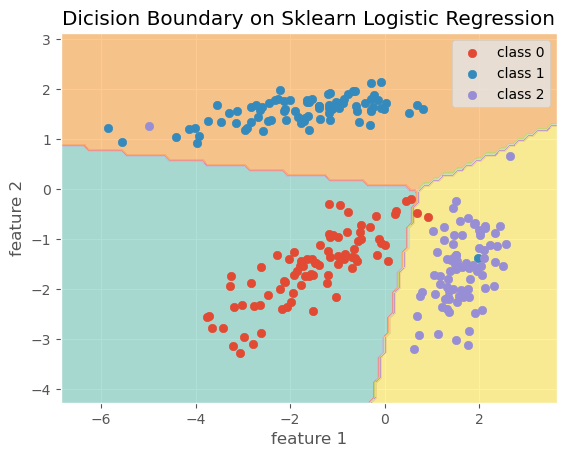

In [25]:
decision_surface(lr_clf, plt, X, N_classes)
plt.xlabel('feature 1')
plt.ylabel('feature 2')
plt.title('Dicision Boundary on Sklearn Logistic Regression')

In the following cell, we are plotting four subplots each one of them is plotting the decision surface for one of the four classifiers created until this point.

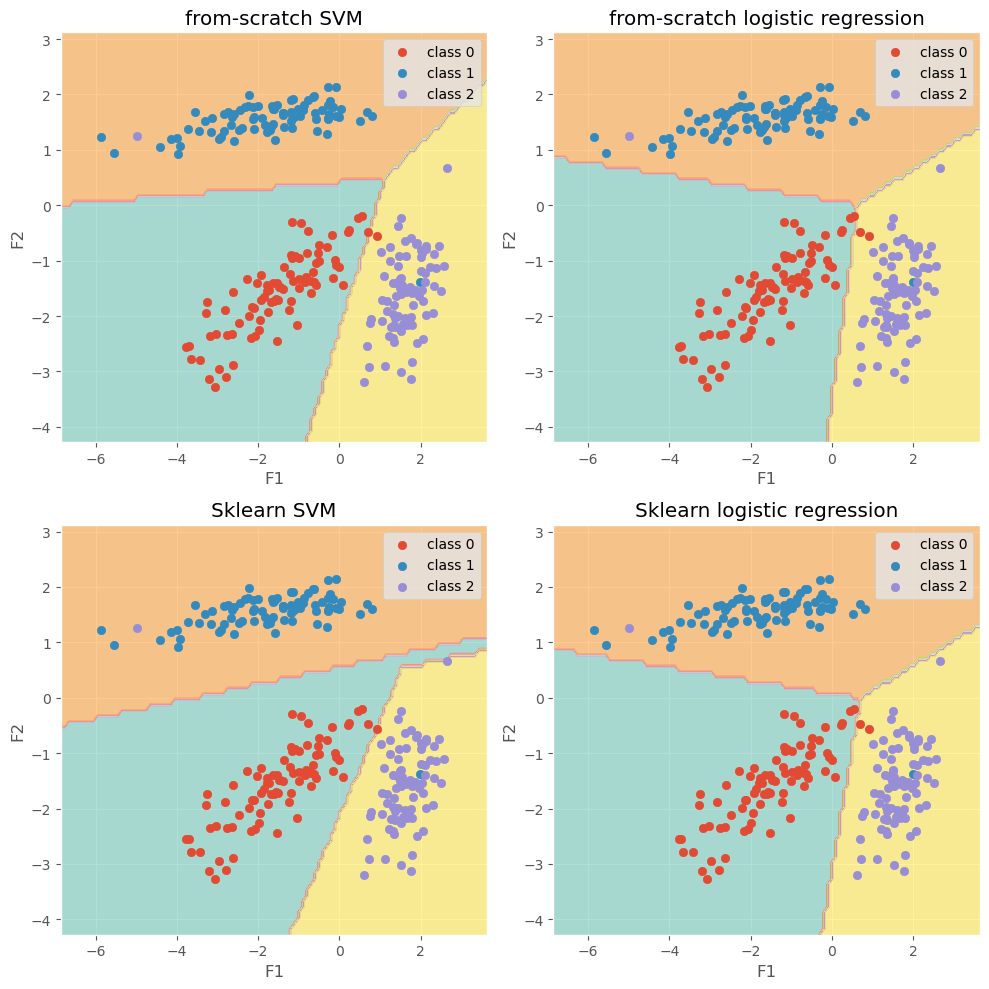

In [26]:
classifiers = [svm_obj, log_obj, svm_clf, lr_clf]
titles = ['from-scratch SVM', 'from-scratch logistic regression', 'Sklearn SVM', 'Sklearn logistic regression']

fig, axs = plt.subplots(2, 2, figsize=(10, 10))

for i in range(2):
    for j in range(2):
        decision_surface(classifiers[i * 2 + j], axs[i][j], X, N_classes)
        axs[i][j].set_xlabel('F1')
        axs[i][j].set_ylabel('F2')
        axs[i][j].set_title(f'{titles[i * 2 + j]}')
        plt.tight_layout()

In the next two cells, we are ploting the overall accuracy on the whole created dataset for all four classifiers in the form of bar graphs.

In [27]:
# creating a dictionary containing the classifier's names as it's keys, and the calculated accuracies on whole dataset as it's values. 
accuracies = {}
accuracies['sklearn SVM'] = np.mean(svm_clf.predict(X) == y)
accuracies['sklearn Logistic reg'] = np.mean(lr_clf.predict(X) == y)
accuracies['implemented SVM'] = svm_obj.accuracy(svm_obj.hypothesis(X, True), y)
accuracies['implemented Logistic reg'] = log_obj.accuracy(log_obj.hypothesis(X, True), y)

Text(0.5, 1.0, 'Accuracies on whole created dataset')

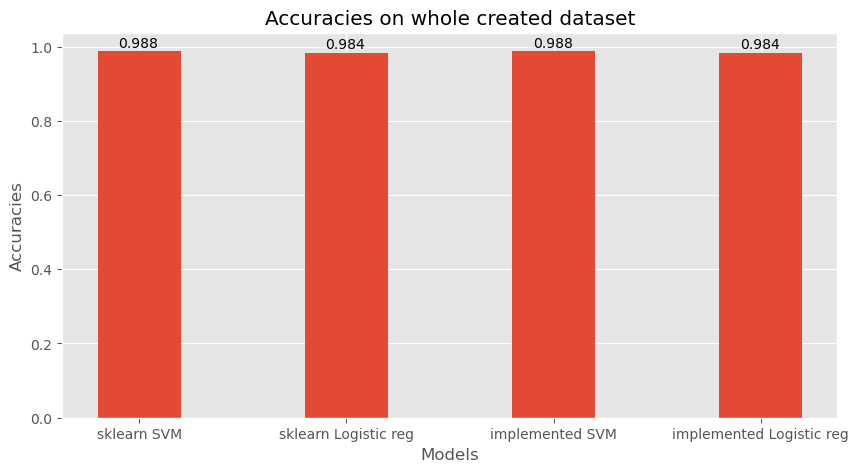

In [28]:
plt.figure(figsize=(10, 5))
plt.bar(accuracies.keys(), height=accuracies.values(), width=0.4)

for i in range(len(accuracies.keys())):
    x_cor = i - 0.1
    y_cor = list(accuracies.values())[i]
    annotation = round(list(accuracies.values())[i], 3)
    plt.annotate(annotation, (x_cor, y_cor + 0.01))

plt.xlabel('Models')
plt.ylabel('Accuracies')
plt.title('Accuracies on whole created dataset')

---
### Train and Test the models on Digits dataset
---

Instantiate an classifier from the `svm_classifier` class, and then train it on the **Digits** dataset for 3000 iterations, in each execution of this function, the accuracy and loss function's value on both train and test data is calculated in each iteration and stored as a list for further analysis.

In [29]:
svm_obj_mn = svm_classifier(reg=1, alpha=2e-5, n_features=64, n_classes=10)

accs_on_train, accs_on_test, loss_on_train, loss_on_test = [], [], [], []

for i in range(3000):
    # estimating loss and accuracy every 100 iterations
    if i % 200 == 0:
        # calculated the both loss and accuracy on training dataset
        loss_on_train.append(svm_obj_mn.full_vectorized_multiclass_hinge_loss(X_train_mn, y_train_mn))
        train_predicted_scores = svm_obj_mn.hypothesis(X_train_mn, True)
        accs_on_train.append(svm_obj_mn.accuracy(train_predicted_scores, y_train_mn))
        
        # calculated the both loss and accuracy on testing dataset
        loss_on_test.append(svm_obj_mn.full_vectorized_multiclass_hinge_loss(X_test_mn, y_test_mn))
        test_predicted_scores = svm_obj_mn.hypothesis(X_test_mn, True)
        accs_on_test.append(svm_obj_mn.accuracy(test_predicted_scores, y_test_mn))
        
    svm_obj_mn.vectorized_update(X_train_mn, y_train_mn)

After the training of the SVM classifier object `svm_obj_mn`, plot the decision surface for it using `decision_surface` function.

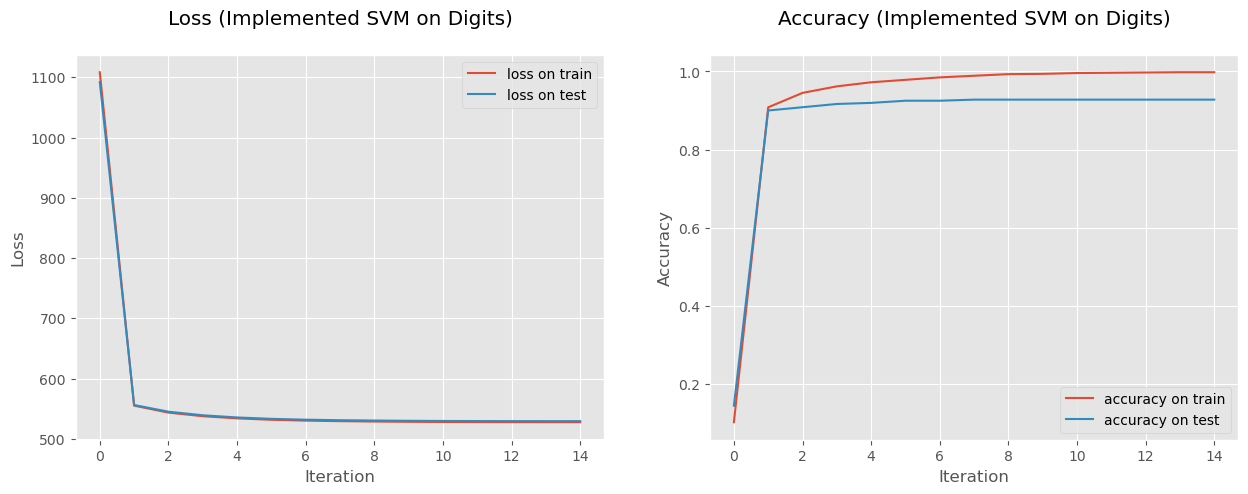

In [30]:
loss_acc_plotter("Implemented SVM on Digits", loss_on_train, loss_on_test, accs_on_train, accs_on_test)

Instantiate an classifier from the `logistic_regression_classifier` class, and then train it on **Digits** dataset for 3000 iterations, in each execution of this function, the accuracy and loss function's value on both train and test data is calculated in each iteration and stored as a list for further analysis.

In [31]:
log_obj_mn = logistic_regression_classifier(reg=1, alpha=2e-5, n_features=64, n_classes=10)

accs_on_train, accs_on_test, loss_on_train, loss_on_test = [], [], [], []

for i in range(3000):
    # estimating loss and accuracy every 100 iterations
    if i % 100 == 0:
        # calculated the both loss and accuracy on training dataset
        loss_on_train.append(log_obj_mn.vectotrized_softmax_loss(X_train_mn, y_train_mn))
        train_predicted_scores = log_obj_mn.hypothesis(X_train_mn, True)
        accs_on_train.append(log_obj_mn.accuracy(train_predicted_scores, y_train_mn))
        
        # calculated the both loss and accuracy on testing dataset
        loss_on_test.append(log_obj_mn.vectotrized_softmax_loss(X_test_mn, y_test_mn))
        test_predicted_scores = log_obj_mn.hypothesis(X_test_mn, True)
        accs_on_test.append(log_obj_mn.accuracy(test_predicted_scores, y_test_mn))
    
    log_obj_mn.vectorized_update(X_train_mn, y_train_mn)

After the training of the Logistic Regression classifier object `log_obj_mn`, plot the decision surface for it using `decision_surface` function.

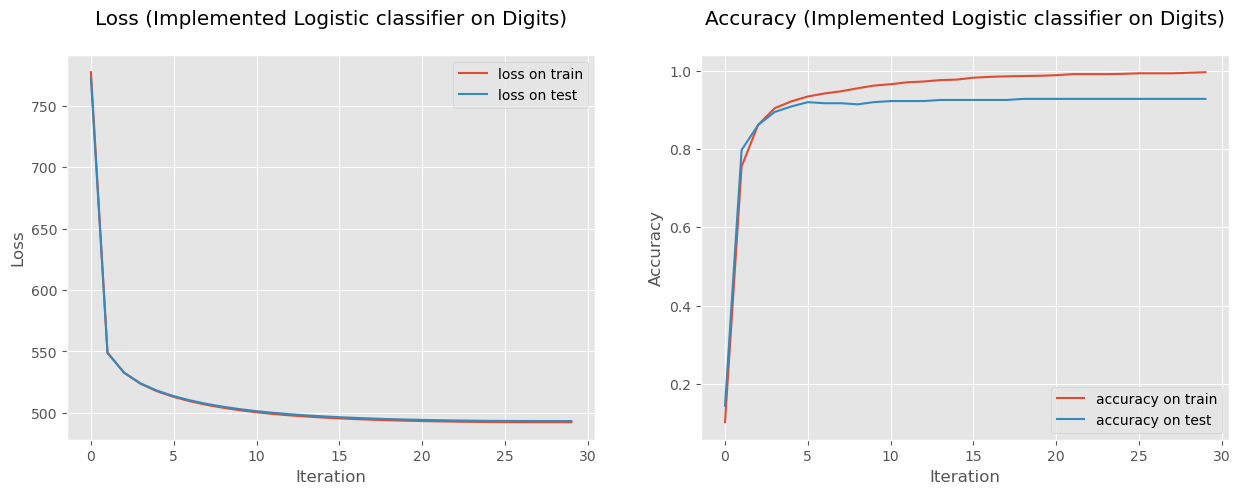

In [32]:
loss_acc_plotter("Implemented Logistic classifier on Digits", loss_on_train, loss_on_test, accs_on_train, accs_on_test)

In the next cell, we are comparing the consumed time for each implementation-type of gradient descent algorithm (naive, vectorized) in `logistic_regression_classifier` on the **Digits** dataset. 

In [33]:
iterations = 100
tic1 = time.time()
for _ in range(iterations):
    log_obj_mn.naive_update(X_train_mn, y_train_mn)
toc1 = time.time()

tic2 = time.time()
for _ in range(iterations):
    log_obj_mn.vectorized_update(X_train_mn, y_train_mn)
toc2 = time.time()

time1 = toc1 - tic1
time2 = toc2 - tic2

print("Logistic Classifier On Digits dataset: ")
print(f"In {iterations} iteration of gradient descent, the vectorized implementation will preform {time1 / time2} times faster than the naive implementation.")

Logistic Classifier On Digits dataset: 
In 100 iteration of gradient descent, the vectorized implementation will preform 41.19475982042648 times faster than the naive implementation.


Create and train both *sklearn svm* and *sklearn logistic regression* on the **Digits** dataset. 

In [34]:
svm_clf_mn = SVC(kernel='linear', C=100)
svm_clf_mn.fit(X_train_mn, y_train_mn)

lr_clf_mn = LogisticRegression(penalty='l2', C=100, solver='lbfgs')
lr_clf_mn.fit(X_train_mn, y_train_mn)

c:\Users\alireza\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(C=100)

In the next two cells, we are ploting the overall accuracy on the **Test set of Digits dataset** for all four classifiers in the form of bar graphs.

In [35]:
# creating a dictionary containing the classifier's names as it's keys, and the calculated accuracies on the Test set of Digits dataset as it's values.

accuracies_on_mn = {}
accuracies_on_mn['sklearn SVM'] = np.mean(svm_clf_mn.predict(X_test_mn) == y_test_mn)
accuracies_on_mn['sklearn Logistic reg'] = np.mean(lr_clf_mn.predict(X_test_mn) == y_test_mn)
accuracies_on_mn['implemented SVM'] = svm_obj_mn.accuracy(svm_obj_mn.hypothesis(X_test_mn, True), y_test_mn)
accuracies_on_mn['implemented Logistic reg'] = log_obj_mn.accuracy(log_obj_mn.hypothesis(X_test_mn, True), y_test_mn)

Text(0.5, 1.0, 'Test data Accuracies on Digits')

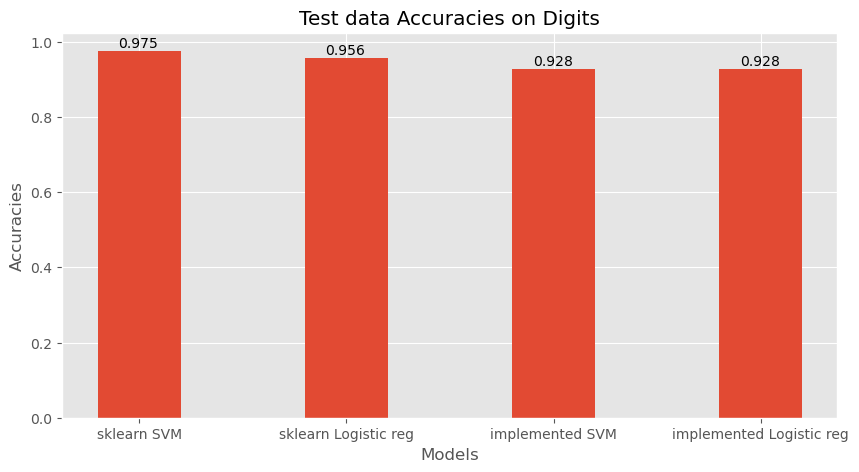

In [36]:
plt.figure(figsize=(10, 5))
plt.bar(accuracies_on_mn.keys(), height=accuracies_on_mn.values(), width=0.4)

for i in range(len(accuracies_on_mn.keys())):
    x_cor = i - 0.1
    y_cor = list(accuracies_on_mn.values())[i]
    annotation = round(list(accuracies_on_mn.values())[i], 3)
    plt.annotate(annotation, (x_cor, y_cor + 0.01))

plt.xlabel('Models')
plt.ylabel('Accuracies')
plt.title('Test data Accuracies on Digits')